In [1]:
import pandas as pd
from sklearn.metrics import r2_score, root_mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import pingouin as pg
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Alternate visualizations

This notebook contains some alternate visualizations of repeated cross validation results which may be useful.

## 1. Data prep

Read the input data

In [2]:
df = pd.read_csv("Sol_regression_ChemProp_LightGBM.csv")

Extract the test sets with butina splits

In [5]:
df_test = df.query("dset == 'test' and group == 'scaffold'")

Create a list of model types

In [6]:
model_list = ["chemprop_mt","chemprop_st","lgbm_morgan"]

Collect $R^2$ and RMSE stats

In [8]:
stat_list = []
for k,v in df_test.groupby("fold"):
    for model in model_list:
        stat_list.append([k,model,r2_score(v.Sol, v[model]),root_mean_squared_error(v.Sol, v[model])])
stat_df = pd.DataFrame(stat_list,columns=["fold","model","r2","rmse"])

## 2. Paired plots

Create a list of model paris for the paired plots.  The paired plots provide a view into individual cross-validation folds. 

In [ ]:
model_pair_list = list(combinations(model_list,2))
model_pair_list

[('chemprop_mt', 'chemprop_st'),
 ('chemprop_mt', 'lgbm_morgan'),
 ('chemprop_st', 'lgbm_morgan')]

Make the paired plots for $R^2$

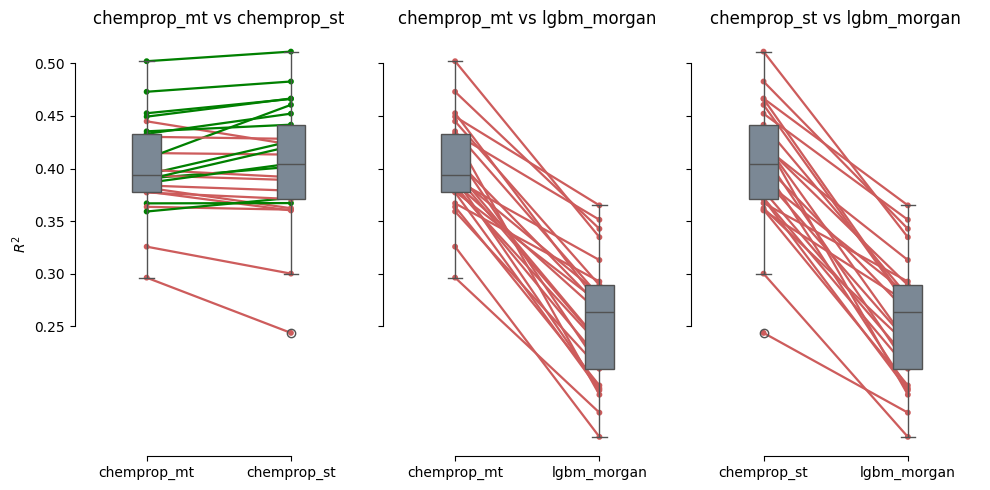

In [18]:
figure, axes = plt.subplots(1,len(model_pair_list),figsize=(10,5),sharey=True)
for idx,p in enumerate(model_pair_list):
    tmp_df = stat_df.query("model in @p")
    ax = pg.plot_paired(tmp_df,dv="r2",within="model",subject="fold",ax=axes[idx])
    ax.set_ylabel("$R^2$")
    ax.set_xlabel("")
    ax.set_title(" vs ".join(p))
plt.tight_layout()

Make the paired plots for RMSE

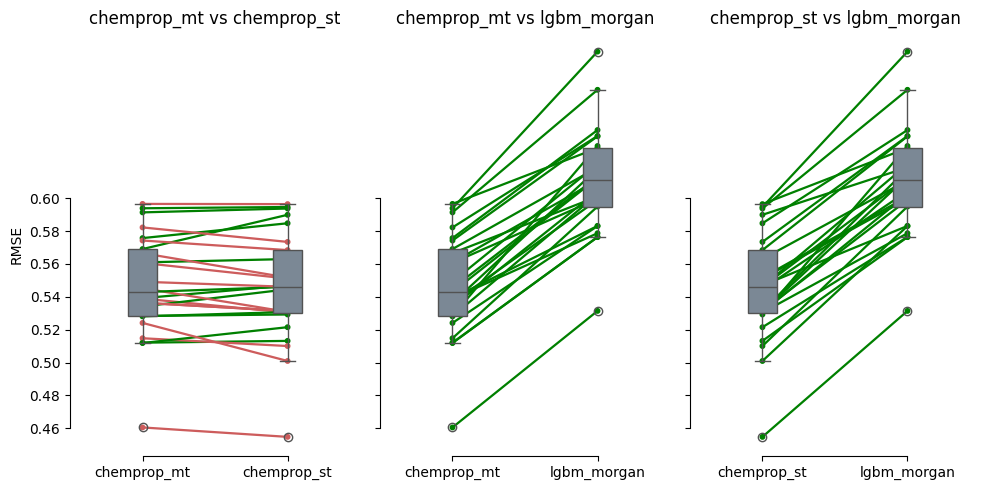

In [ ]:
figure, axes = plt.subplots(1,len(model_pair_list),figsize=(10,5),sharey=True)
for idx,p in enumerate(model_pair_list):
    tmp_df = stat_df.query("model in @p")
    ax = pg.plot_paired(tmp_df,dv="rmse",within="model",subject="fold",ax=axes[idx])
    ax.set_title(" vs ".join(p))
    ax.set_ylabel("RMSE")
    ax.set_xlabel("")
plt.tight_layout()

## 3. Tukey HSD confidence intervals and reference model comparisons

Calculate [Tukey's Honestly Significant Difference (HSD)](https://en.wikipedia.org/wiki/Tukey%27s_range_test) for $R^2$.  This allows us to determine whether we can reject the null hypothesis that the means of the distributions are the same. 

In [12]:
tukey_res = pairwise_tukeyhsd(endog=stat_df.r2,groups=stat_df.model)
print(tukey_res)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1      group2   meandiff p-adj   lower   upper  reject
--------------------------------------------------------------
chemprop_mt chemprop_st   0.0026 0.9843 -0.0344  0.0397  False
chemprop_mt lgbm_morgan  -0.1476    0.0 -0.1847 -0.1105   True
chemprop_st lgbm_morgan  -0.1502    0.0 -0.1873 -0.1132   True
--------------------------------------------------------------


Plot confidence intervals for Tukey's HSD.  In this case, we use ChemProp multitask  as the reference.  Any pair where we can reject the null hypothesis will be shown in red. 

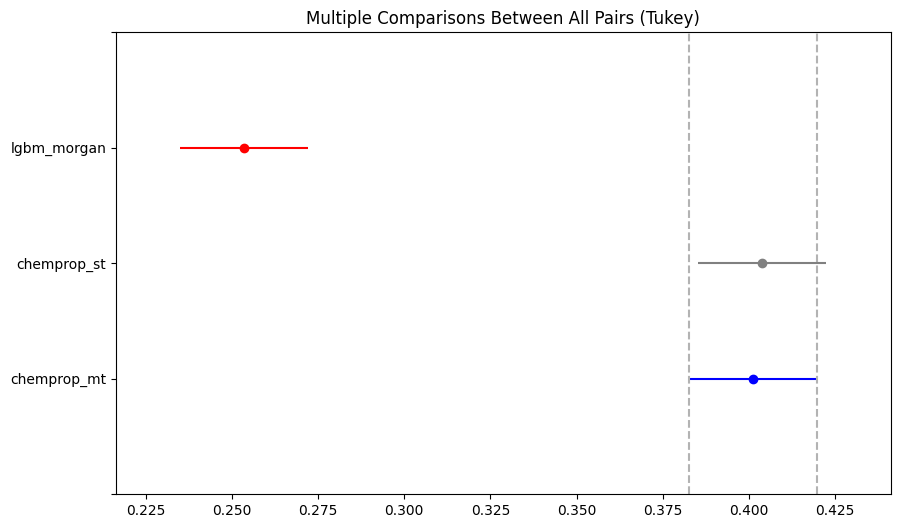

In [14]:
_ = tukey_res.plot_simultaneous(comparison_name="chemprop_mt")

Calculate Tukey's Honestly Significant Difference (HSD) for RMSE

In [16]:
tukey_res = pairwise_tukeyhsd(endog=stat_df.rmse,groups=stat_df.model)
print(tukey_res)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
chemprop_mt chemprop_st  -0.0015 0.9849 -0.0234 0.0203  False
chemprop_mt lgbm_morgan   0.0634    0.0  0.0416 0.0853   True
chemprop_st lgbm_morgan   0.0649    0.0  0.0431 0.0868   True
-------------------------------------------------------------


Plot confidence intervals for Tukey's HSD.  In this case, we use ChemProp multitask as the reference.  Any pair where we can reject the null hypothesis will be shown in red. 

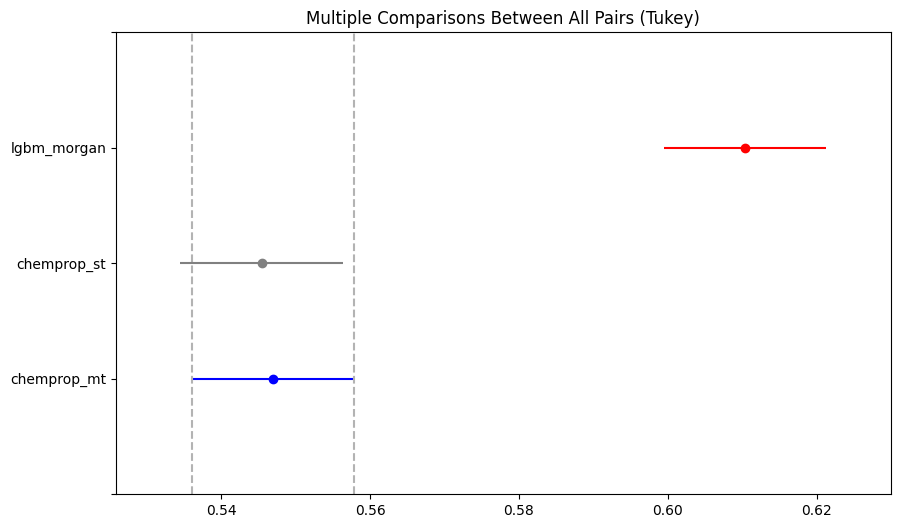

In [17]:
_ = tukey_res.plot_simultaneous(comparison_name="chemprop_mt")